# py-yardstick Demo: Performance Metrics

This notebook demonstrates the py-yardstick package for model evaluation metrics.

py-yardstick provides:
- Time series metrics (RMSE, MAE, MAPE, SMAPE, MASE, R²)
- Residual diagnostic tests (Durbin-Watson, Ljung-Box, Shapiro-Wilk, ADF)
- Classification metrics (Accuracy, Precision, Recall, F-measure, ROC AUC)
- Metric set composition for batch evaluation

In [19]:
# !pip install seaborn

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from py_yardstick import (
    # Time Series Metrics
    rmse, mae, mape, smape, mase, r_squared, rsq_trad, mda,
    # Residual Diagnostics
    durbin_watson, ljung_box, shapiro_wilk, adf_test,
    # Classification Metrics
    accuracy, precision, recall, f_meas, roc_auc,
    # Metric Set
    metric_set
)

# Set random seed for reproducibility
np.random.seed(42)

## 1. Time Series Regression Metrics

Let's create some example predictions and calculate various metrics.

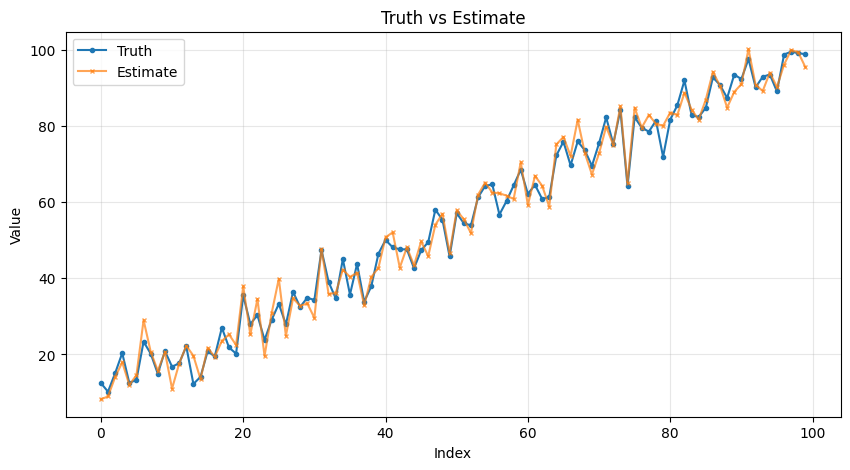

In [21]:
# Create example data
n = 100
truth = pd.Series(np.linspace(10, 100, n) + np.random.normal(0, 5, n))
estimate = truth + np.random.normal(0, 3, n)

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(truth.values, label='Truth', marker='o', markersize=3)
plt.plot(estimate.values, label='Estimate', marker='x', markersize=3, alpha=0.7)
plt.legend()
plt.title('Truth vs Estimate')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

### Individual Metrics

In [22]:
# RMSE - Root Mean Squared Error
print("RMSE:")
print(rmse(truth, estimate))
print()

RMSE:
  metric     value
0   rmse  2.847452



In [23]:
# MAE - Mean Absolute Error
print("MAE:")
print(mae(truth, estimate))
print()

MAE:
  metric    value
0    mae  2.26862



In [24]:
# MAPE - Mean Absolute Percentage Error
print("MAPE (percentage):")
print(mape(truth, estimate))
print()

MAPE (percentage):
  metric     value
0   mape  6.085179



In [25]:
# SMAPE - Symmetric Mean Absolute Percentage Error
print("SMAPE (percentage, bounded 0-200):")
print(smape(truth, estimate))
print()

SMAPE (percentage, bounded 0-200):
  metric    value
0  smape  6.06894



In [26]:
# R-squared
print("R-squared:")
print(r_squared(truth, estimate))
print()

print("R-squared Traditional (squared correlation):")
print(rsq_trad(truth, estimate))
print()

R-squared:
      metric     value
0  r_squared  0.988733

R-squared Traditional (squared correlation):
     metric     value
0  rsq_trad  0.988828



### MASE - Mean Absolute Scaled Error

MASE requires training data to compute the scaling factor.

In [27]:
# Split data into train and test
train_truth = truth[:70]
test_truth = truth[70:]
test_estimate = estimate[70:]

print("MASE (scaled by naive forecast on training data):")
print(mase(test_truth, test_estimate, train=train_truth, m=1))
print()

MASE (scaled by naive forecast on training data):
  metric     value
0   mase  0.388034



### MDA - Mean Directional Accuracy

MDA measures how often the predicted direction matches the actual direction (useful for time series).

In [28]:
print("MDA (proportion of correct directional predictions):")
print(mda(truth, estimate))
print()

MDA (proportion of correct directional predictions):
  metric     value
0    mda  0.828283



## 2. Metric Set - Compute Multiple Metrics at Once

Use `metric_set()` to create a custom collection of metrics that can be computed together.

In [29]:
# Create a metric set
my_metrics = metric_set(rmse, mae, mape, r_squared, mda)

# Compute all metrics at once
results = my_metrics(truth, estimate)
print("All metrics computed together:")
print(results)
print()

All metrics computed together:
      metric     value
0       rmse  2.847452
1        mae  2.268620
2       mape  6.085179
3  r_squared  0.988733
4        mda  0.828283



## 3. Residual Diagnostic Tests

These tests help evaluate model assumptions and residual properties.

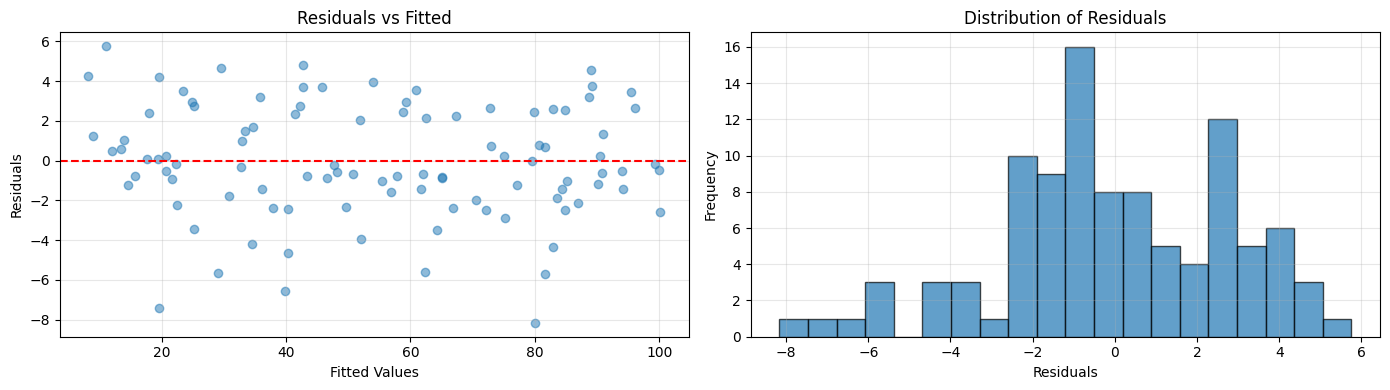

In [30]:
# Compute residuals
residuals = truth - estimate

# Visualize residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Residuals plot
axes[0].scatter(estimate, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')
axes[0].grid(True, alpha=0.3)

# Histogram of residuals
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Durbin-Watson Test

Tests for autocorrelation in residuals. Values range from 0 to 4:
- 2 = no autocorrelation
- < 2 = positive autocorrelation
- > 2 = negative autocorrelation

In [31]:
print("Durbin-Watson Test:")
dw_result = durbin_watson(residuals)
print(dw_result)
print(f"\nInterpretation: DW = {dw_result['value'].iloc[0]:.3f}")
if dw_result['value'].iloc[0] < 1.5:
    print("→ Positive autocorrelation detected")
elif dw_result['value'].iloc[0] > 2.5:
    print("→ Negative autocorrelation detected")
else:
    print("→ Little or no autocorrelation")
print()

Durbin-Watson Test:
          metric     value
0  durbin_watson  2.147066

Interpretation: DW = 2.147
→ Little or no autocorrelation



### Ljung-Box Test

Tests for autocorrelation up to a specified lag. Returns both test statistic and p-value.

In [32]:
print("Ljung-Box Test (10 lags):")
lb_result = ljung_box(residuals, lags=10)
print(lb_result)
p_value = lb_result[lb_result['metric'] == 'ljung_box_p']['value'].iloc[0]
print(f"\nInterpretation: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("→ Reject null hypothesis: autocorrelation present")
else:
    print("→ Fail to reject null hypothesis: no significant autocorrelation")
print()

Ljung-Box Test (10 lags):
           metric  value
0  ljung_box_stat    NaN
1     ljung_box_p    NaN

Interpretation: p-value = nan
→ Fail to reject null hypothesis: no significant autocorrelation



### Shapiro-Wilk Test

Tests for normality of residuals.

In [33]:
print("Shapiro-Wilk Normality Test:")
sw_result = shapiro_wilk(residuals)
print(sw_result)
p_value = sw_result[sw_result['metric'] == 'shapiro_wilk_p']['value'].iloc[0]
print(f"\nInterpretation: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("→ Reject null hypothesis: residuals are not normally distributed")
else:
    print("→ Fail to reject null hypothesis: residuals appear normally distributed")
print()

Shapiro-Wilk Normality Test:
              metric     value
0  shapiro_wilk_stat  0.977534
1     shapiro_wilk_p  0.085256

Interpretation: p-value = 0.0853
→ Fail to reject null hypothesis: residuals appear normally distributed



### Augmented Dickey-Fuller Test

Tests for stationarity in a time series.

In [34]:
print("Augmented Dickey-Fuller Test (testing stationarity of truth series):")
adf_result = adf_test(truth)
print(adf_result)
p_value = adf_result[adf_result['metric'] == 'adf_p']['value'].iloc[0]
print(f"\nInterpretation: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("→ Reject null hypothesis: series is stationary")
else:
    print("→ Fail to reject null hypothesis: unit root present (non-stationary)")
print()

Augmented Dickey-Fuller Test (testing stationarity of truth series):
     metric     value
0  adf_stat  0.071208
1     adf_p  0.964039

Interpretation: p-value = 0.9640
→ Fail to reject null hypothesis: unit root present (non-stationary)



## 4. Classification Metrics

Let's create binary classification data and evaluate performance.

In [35]:
# Create classification data
n_samples = 200
truth_class = pd.Series(np.random.binomial(1, 0.5, n_samples))

# Generate predictions (probabilities)
# Good classifier: higher prob for class 1, lower for class 0
probs = truth_class * np.random.beta(8, 2, n_samples) + (1 - truth_class) * np.random.beta(2, 8, n_samples)
estimate_probs = pd.Series(probs)

# Convert to class labels
estimate_class = pd.Series((estimate_probs > 0.5).astype(int))

print(f"True class distribution: {truth_class.value_counts().to_dict()}")
print(f"Predicted class distribution: {estimate_class.value_counts().to_dict()}")

True class distribution: {1: 104, 0: 96}
Predicted class distribution: {1: 101, 0: 99}


### Confusion Matrix Visualization

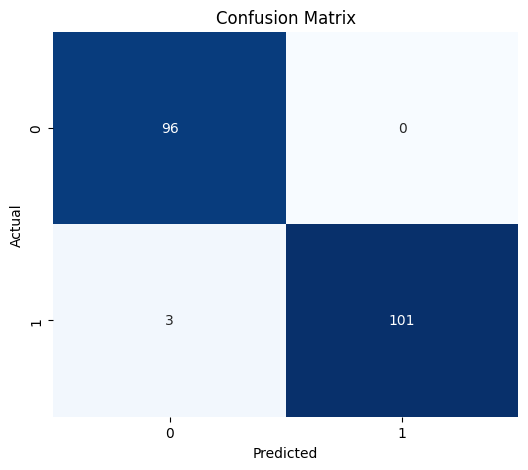

True Negatives: 96
False Positives: 0
False Negatives: 3
True Positives: 101


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(truth_class, estimate_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

### Classification Metrics

In [37]:
# Accuracy
print("Accuracy:")
print(accuracy(truth_class, estimate_class))
print()

# Precision
print("Precision:")
print(precision(truth_class, estimate_class))
print()

# Recall
print("Recall:")
print(recall(truth_class, estimate_class))
print()

# F1-Score
print("F1-Score:")
print(f_meas(truth_class, estimate_class))
print()

Accuracy:
     metric  value
0  accuracy  0.985

Precision:
      metric  value
0  precision    1.0

Recall:
   metric     value
0  recall  0.971154

F1-Score:
   metric     value
0  f_meas  0.985366



### ROC AUC (requires probabilities)

In [38]:
print("ROC AUC:")
print(roc_auc(truth_class, estimate_probs))
print()

ROC AUC:
    metric  value
0  roc_auc    1.0



### ROC Curve Visualization

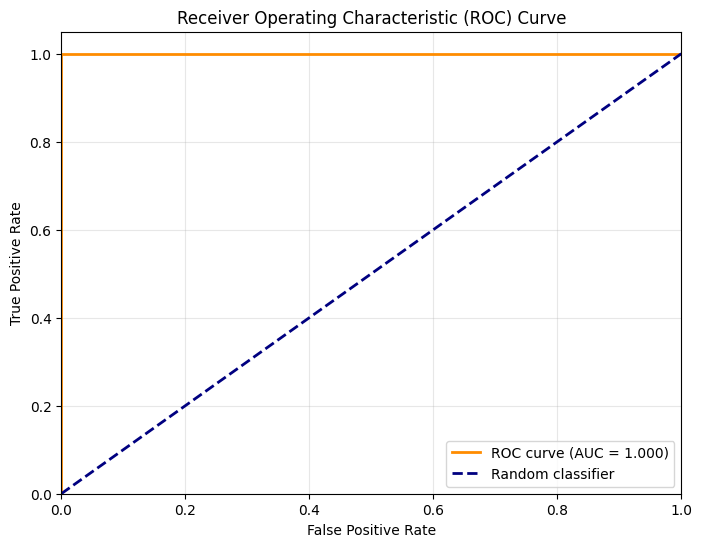

In [39]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(truth_class, estimate_probs)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### Classification Metric Set

In [40]:
# Create classification metric set
clf_metrics = metric_set(accuracy, precision, recall, f_meas)

# Compute all at once
clf_results = clf_metrics(truth_class, estimate_class)
print("Classification Metrics Summary:")
print(clf_results)

Classification Metrics Summary:
      metric     value
0   accuracy  0.985000
1  precision  1.000000
2     recall  0.971154
3     f_meas  0.985366


## 5. Integration with py-parsnip Models

Let's use yardstick metrics with actual model predictions from py-parsnip.

In [41]:
from py_parsnip import linear_reg
from py_rsample import initial_time_split, training, testing

# Create sample time series data
np.random.seed(42)
n = 200
dates = pd.date_range('2020-01-01', periods=n, freq='D')
sales_data = pd.DataFrame({
    'date': dates,
    'price': np.random.uniform(10, 50, n),
    'promotion': np.random.binomial(1, 0.3, n),
    'sales': 100 + np.random.uniform(0, 20, n) * np.sin(np.linspace(0, 4*np.pi, n)) + np.random.normal(0, 5, n)
})

# Add effects
sales_data['sales'] = sales_data['sales'] - 0.5 * sales_data['price'] + 10 * sales_data['promotion']

print("Sample data:")
print(sales_data.head())
print(f"\nShape: {sales_data.shape}")

Sample data:
        date      price  promotion      sales
0 2020-01-01  24.981605          0  84.857910
1 2020-01-02  48.028572          0  73.160473
2 2020-01-03  39.279758          0  81.097798
3 2020-01-04  33.946339          1  90.963250
4 2020-01-05  16.240746          0  90.711072

Shape: (200, 4)


In [42]:
# Train/test split
split = initial_time_split(sales_data, prop=0.75)
train_data = training(split)
test_data = testing(split)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 150
Testing samples: 50


In [43]:
# Fit model
model = linear_reg().set_engine('sklearn')
fit = model.fit(train_data, 'sales ~ price + promotion')

# Get predictions
train_preds = fit.predict(train_data)
test_preds = fit.predict(test_data)

print("Training predictions:")
print(train_preds.head())
print("\nTest predictions:")
print(test_preds.head())

Training predictions:
       .pred
0  90.345649
1  78.020132
2  82.698998
3  92.764385
4  95.020261

Test predictions:
        .pred
0   78.928189
1  100.446179
2   95.258220
3   87.887438
4   77.272778


In [44]:
# Evaluate with yardstick metrics
train_truth = train_data['sales']
train_estimate = train_preds['.pred']

test_truth = test_data['sales']
test_estimate = test_preds['.pred']

# Define metric set
regression_metrics = metric_set(rmse, mae, mape, r_squared)

# Compute metrics for both train and test
train_metrics = regression_metrics(train_truth, train_estimate)
train_metrics['split'] = 'train'

test_metrics = regression_metrics(test_truth, test_estimate)
test_metrics['split'] = 'test'

# Combine
all_metrics = pd.concat([train_metrics, test_metrics], ignore_index=True)

print("\nModel Performance Metrics:")
print(all_metrics.pivot(index='metric', columns='split', values='value'))


Model Performance Metrics:
split           test      train
metric                         
mae         8.541530   7.949911
mape       11.167344   9.103595
r_squared  -0.087852   0.319495
rmse       10.651941  10.273474


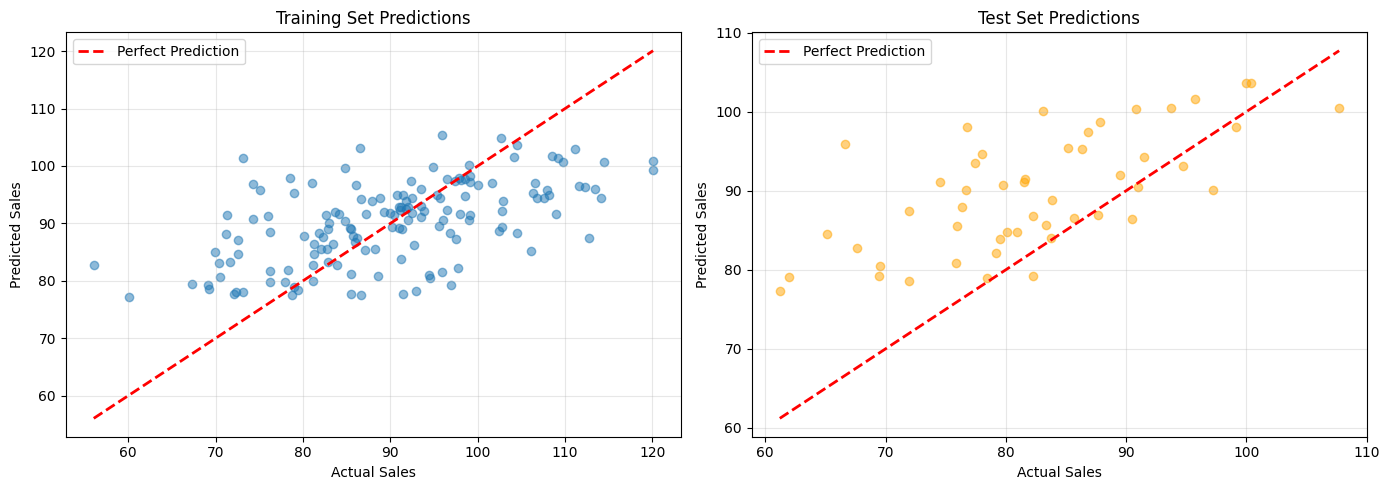

In [45]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training
axes[0].scatter(train_truth, train_estimate, alpha=0.5)
axes[0].plot([train_truth.min(), train_truth.max()], 
             [train_truth.min(), train_truth.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Training Set Predictions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing
axes[1].scatter(test_truth, test_estimate, alpha=0.5, color='orange')
axes[1].plot([test_truth.min(), test_truth.max()], 
             [test_truth.min(), test_truth.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Sales')
axes[1].set_ylabel('Predicted Sales')
axes[1].set_title('Test Set Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparing Multiple Models

Use yardstick to compare different model configurations.

In [46]:
# Fit multiple models
model1 = linear_reg().set_engine('sklearn')  # OLS
model2 = linear_reg(penalty=0.1).set_engine('sklearn')  # Ridge
model3 = linear_reg(penalty=1.0).set_engine('sklearn')  # Ridge with more regularization

fit1 = model1.fit(train_data, 'sales ~ price + promotion')
fit2 = model2.fit(train_data, 'sales ~ price + promotion')
fit3 = model3.fit(train_data, 'sales ~ price + promotion')

# Get test predictions
pred1 = fit1.predict(test_data)['.pred']
pred2 = fit2.predict(test_data)['.pred']
pred3 = fit3.predict(test_data)['.pred']

# Compute metrics
metrics1 = regression_metrics(test_truth, pred1)
metrics1['model'] = 'OLS'

metrics2 = regression_metrics(test_truth, pred2)
metrics2['model'] = 'Ridge (0.1)'

metrics3 = regression_metrics(test_truth, pred3)
metrics3['model'] = 'Ridge (1.0)'

# Combine and pivot
comparison = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
comparison_wide = comparison.pivot(index='metric', columns='model', values='value')

print("\nModel Comparison:")
print(comparison_wide)


Model Comparison:
model            OLS  Ridge (0.1)  Ridge (1.0)
metric                                        
mae         8.541530     8.540385     8.530417
mape       11.167344    11.166592    11.160049
r_squared  -0.087852    -0.088013    -0.089523
rmse       10.651941    10.652728    10.660119


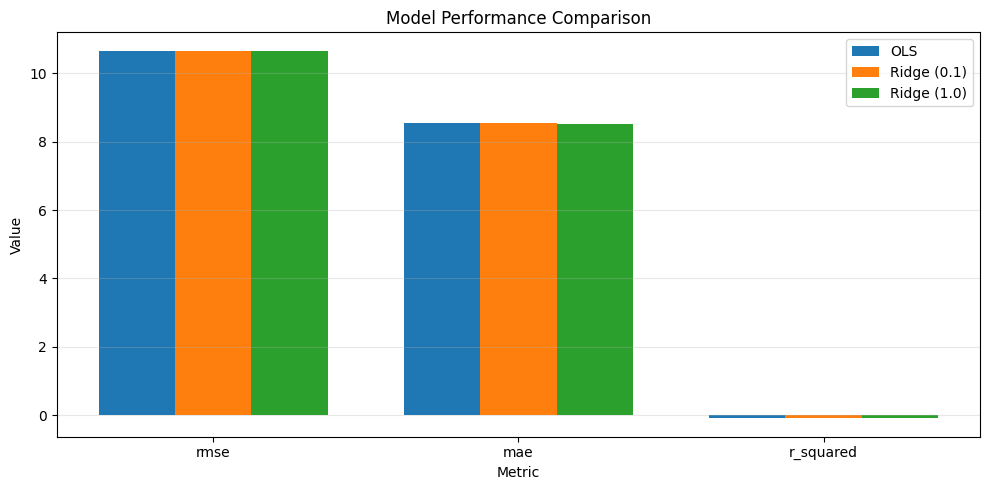

In [47]:
# Visualize comparison
comparison_plot = comparison[comparison['metric'].isin(['rmse', 'mae', 'r_squared'])]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(comparison_plot['metric'].unique()))
width = 0.25
models = comparison_plot['model'].unique()

for i, model in enumerate(models):
    model_data = comparison_plot[comparison_plot['model'] == model]
    ax.bar(x + i*width, model_data['value'], width, label=model)

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_plot['metric'].unique())
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Time Series Metrics**: RMSE, MAE, MAPE, SMAPE, MASE, R², MDA
2. **Metric Sets**: Composing multiple metrics for batch evaluation
3. **Residual Diagnostics**: Durbin-Watson, Ljung-Box, Shapiro-Wilk, ADF tests
4. **Classification Metrics**: Accuracy, Precision, Recall, F-measure, ROC AUC
5. **Integration**: Using yardstick with py-parsnip models
6. **Model Comparison**: Evaluating multiple models systematically

All metrics follow a consistent API:
- Accept truth and estimate as primary arguments
- Return standardized DataFrames with `metric` and `value` columns
- Can be composed using `metric_set()` for batch evaluation
- Handle edge cases gracefully (NaN values, empty data, etc.)